## import

In [1]:
import json
import numpy as np
import pandas as pd
import folium
from folium import plugins
from folium.features import DivIcon
import matplotlib.pylab as plt
import seaborn as sns

plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)
import warnings ; warnings.filterwarnings('ignore')

## Read Data

In [2]:
GJ_economic = pd.read_csv('../data/경제정보_gwangjin.csv').set_index('행정동')
GJ_food = pd.read_csv('../data/경제정보_gwangjin_food.csv').set_index('행정동')

FT = pd.read_csv('../data/gwangjingu_FT.csv').set_index('행정동')

In [3]:
result = pd.read_csv('../data/gwangjingu_score.csv')
result['행정구역'] = result['행정동'].apply(lambda x: f'광진구 {x}')

In [4]:
seoul_dong = json.load(open('../data/HangJeongDong_ver20230101.geojson', encoding='utf-8'))
gwangjin = dict(zip(result['행정구역'], [[] for i in range(15)]))

for i in seoul_dong['features']:
    if i['properties']['sggnm']=="광진구":
        gwangjin[i['properties']['temp']].append(np.mean(i['geometry']['coordinates'][0][0], axis=0))

In [5]:
# 각 값을 조금씩 조정한다.
gwangjin['광진구 군자동'] = [gwangjin['광진구 군자동'][0] + np.array([0,0.002])]
gwangjin['광진구 중곡1동'] = [gwangjin['광진구 중곡1동'][0] + np.array([0,0.002])]
gwangjin['광진구 중곡2동'] = [gwangjin['광진구 중곡2동'][0] + np.array([0.001,0.002])]
gwangjin['광진구 중곡4동'] = [gwangjin['광진구 중곡4동'][0] - np.array([0,0.004])]
gwangjin['광진구 화양동'] = [gwangjin['광진구 화양동'][0] - np.array([0.003,0])]
gwangjin['광진구 자양1동'] = [gwangjin['광진구 자양1동'][0] + np.array([0,0.001])]
gwangjin['광진구 구의1동'] = [gwangjin['광진구 구의1동'][0] + np.array([0.004,0])]
gwangjin['광진구 구의3동'] = [gwangjin['광진구 구의3동'][0] + np.array([0.002,0])]

result = result.merge(pd.DataFrame(gwangjin).T.reset_index().rename(columns={'index':'행정구역',0:'좌표'}), on='행정구역')

## 행정동 별 음식물류폐기물위험지수 시각화

In [ ]:
g_map = folium.Map(location = [37.5442, 127.0992], tiles='openstreetmap', zoom_start=13)
g_map.choropleth(geo_data=seoul_dong, data=result, columns=['행정구역', '위험지수_음식물류폐기물'], key_on='properties.temp',
                 fill_color='YlGn', fill_opacity=0.8, 
                 line_opacity=0.4, nan_fill_color='darkgray', legend_name='음식물류폐기물 위험지수')

for _, dong, score, xy in result[['행정동','위험지수_음식물류폐기물','좌표']].itertuples():
    folium.Marker([xy[1], xy[0]-0.003], icon=DivIcon(html=f'<div style="width:50px; height:50px;font-weight: bold;font-size: 5pt">{dong}\n{np.round(score,3)}</div>')).add_to(g_map)
    
g_map

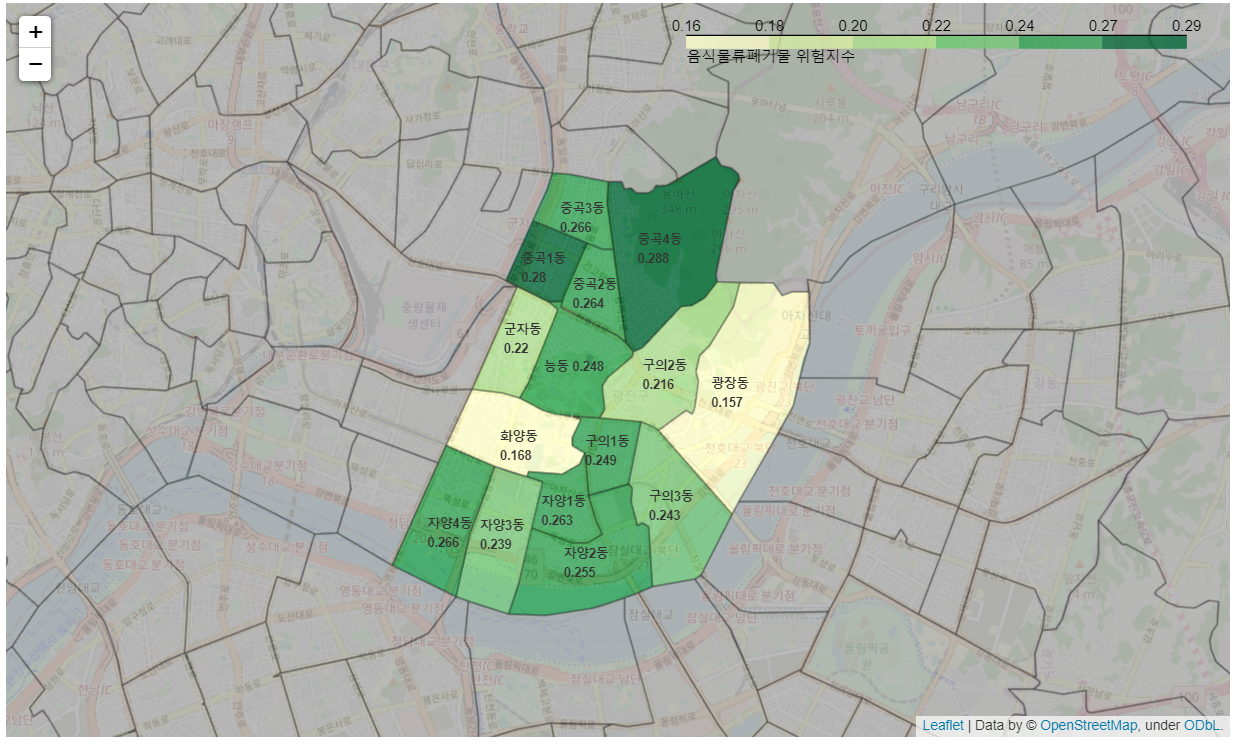

### $\blacktriangleright$ 중곡 4동
- 60대 인구가 많으며 60대 주민 1명이 1개 식품 관련 점포에서 쓸 금액 또한 높다.
- 보건복지부 “2020년도 노인실태조사”에 따르면 60대 노인은 식재료 양을 잘못 선택하거나 잘못 보관하는 어려움을 겪는다고 한다.
- 60대 노인의 거주지가 밀집된 곳에 RFID 음식물처리기기를 설치한다. 이때, 경로당과 가까운 곳으로 입지를 선정해 이용률이 저조할 문제를 예방한다.
- 예약제 식재료 판매 시스템 구축: 광진구는 노인들이 필요한 양만큼만 식재료를 구매할 수 있는 예약제 식재료 판매 시스템을 구축할 수 있습니다. 노인들은 인터넷이나 전화를 통해 필요한 양을 예약하고, 필요한 날짜와 시간에 식료품을 수령할 수 있습니다.
- https://www.korea.kr/news/reporterView.do?newsId=148678885

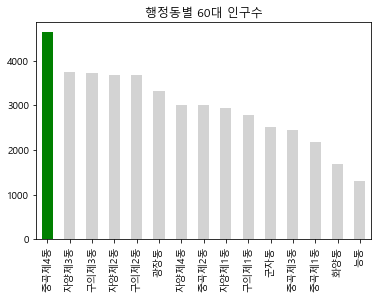

In [6]:
ease = pd.read_csv('../data/raw/서울특별시 광진구_연령별인구현황_20230101.csv', encoding='cp949')
ease.loc[60:69, "중곡제1동":"군자동"].astype('i').sum(axis=0).sort_values(ascending=False)\
.plot.bar(title="행정동별 60대 인구수", color=['green']+['lightgray']*14)
plt.show()

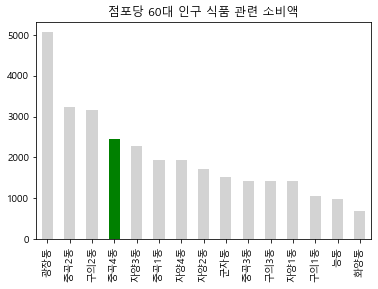

In [7]:
GJ_food['점포수대비매출'] = GJ_food.iloc[:,-1]/GJ_food['점포수']
GJ_food['점포수대비매출'].sort_values(ascending=False)\
.plot.bar(title="점포당 60대 인구 식품 관련 소비액", color=['lightgray']*3+['green']+['lightgray']*11)
plt.xlabel('')
plt.show()

### $\blacktriangleright$ 중곡 1동
  - 5호선과 7호선의 군자역, 7호선의 중곡역과 인접한 지역으로 유동성이 좋아 금요일과 주말에 상권이 활성화된다.
  - 상권 이용이 늘어남은 음식물류폐기물 발생으로 이어질 것이다.
  - 중곡 1동 음식물류폐기물 수거일을 조정해야 한다.

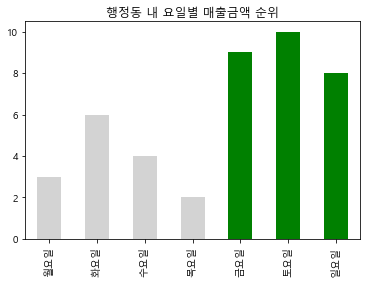

In [8]:
ease = GJ_economic[[i for i in GJ_economic.columns if '요일' in i]].rank(axis=0).loc['중곡1동']
ease.index = [f'{i}요일' for i in '월화수목금토일']
ease.plot.bar(title="행정동 내 요일별 매출금액 순위", color=['lightgray']*4+['green']*3)
plt.show()